# Hollow Core Fibre with an Adiabatic Absorber 

The aim of this example is to provide a slightly more real world example. It is based of a SEM image I stole of one of my mates. If you are interested it has been published here:  

[Sorry its behind a paywall](https://ieeexplore.ieee.org/abstract/document/9113432)

These structures are interesting because they confine light using anti-resonant effects (like interference of a thin film). As opposed to a potential well. This means that they don't really have guided modes: just solutions where light escapes really slowly. This means that the propagation constant isn't super interesting (they basically guide in air). The important property here is the confinement loss and to caculate this we will use an absorbing layer.        

First we will set up a function to import the image so we can turn it into a refractive index profile. 

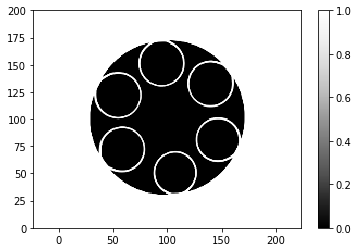

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cst

import os 
os.chdir('../')

from philsol.classy import phil_class
os.chdir('examples')

def bmp_to_array(file):
    """
    Convert from a greyscale bpm to a 2D numpy array of normalised floats.
    """
    img = Image.open(file).convert('L')
    img_array = np.asarray(img.getdata(),dtype=np.float64).reshape((img.size[1],img.size[0]))
    img_array /= 255
    
    return img_array 

index_array = bmp_to_array('hollow_core.bmp')

plt.figure()
plt.pcolor(index_array, cmap = 'Greys_r')
plt.axis('equal')
plt.colorbar()

Let's turn this thing into a refractive index profile. To do this we will assume all the bits which are white are Silica and we will assume all the bits which are black are Air. We will also need to introduce absorbtion to the outer section to calculate the confinement loss. 


The absorbing layer we will use is basically a radial PML and is defined:
$$
n_{PML}(x,y) = s_r(x,y) n(x,y) 
$$

$$
s_r = 
\begin{cases}
1 - i \frac{3 \lambda}{4\pi \Delta r} \frac{x^2 + y^2 - r_0^2}{\Delta r^2} ln[1/R] & for & x^2 + y^2 > r_0^2 \\
1 & for &  x^2 + y^2 < r_0^2
\end{cases}
$$

If you are interested I stole the formula from [this](https://doi.org/10.1364/OE.19.001594) paper and monkeyed around with the coordinates to make it radial. Basically we are saying after a fixed radius we are artificially making the material begin to absorb outgoing radiation. There is lots of theory behind setting these parameters but the important one is R. This is some sort of reflectivity parameter and should be between 1 and 0.   



<ipython-input-18-c77f23fb4efa>:57: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(leakymodes.x, leakymodes.x, abs(leakymodes.n[:,:,0]), cmap = 'Greys_r')


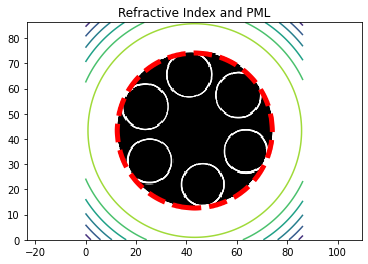

In [18]:
def RefSilica(lam):
    # Selimeir equation for Silica
    
    B1 = 0.6961663
    B2 = 0.4079426
    B3 = 0.8974794
    C1 = 0.0684043**2
    C2 = 0.1162414 **2
    C3 = 9.896161**2
            
    n_square = ( 1  +  B1 * lam**2 / (lam**2 - C1) 
                    +  B2 * lam**2 / (lam**2 - C2) 
                    +  B3 * lam**2 / (lam**2 - C3) )
    
    return n_square**0.5 


def n_PML(n, dx, r_PML, lam):
    R = .001 # PML reflectivity
    points = np.shape(n)[0]
    s = np.ones([points,points], dtype = complex)
    for i in range(points):
        for j in range(points):
            r = np.sqrt((j-points/2)**2 + (i-points/2)**2)
            x = (r - r_PML) / (points - r_PML)
            x_max = (points - r_PML) * dx 
            if r > r_PML:
                s_PML = -3j * lam * np.log(1 / R) / (4. *x_max* cst.pi * abs(max(n[i,j,:]))) 
                s_PML = 1 + s_PML * x**2
                s[i,j] = s_PML
            else: 
                s[i,j] = 1.
                
    return s[:,:,np.newaxis] * n 


# Set wavelength and set the size of each pixel  
lam = .6
k = 2. * cst.pi / lam 
dx = 26. / 60.
n = (RefSilica(lam) - 1.) * bmp_to_array('hollow_core.bmp')[:,:,np.newaxis] + 1.   
n = np.repeat(n,3, axis = 2) 



r_PML = 70 # radius of pml we set this to the radius of the outer jacket 
n_P = n_PML(n, dx, r_PML, lam)


# make a class instance with the parameter of our fibre 
leakymodes = phil_class(n_P, k, dx = dx, dy = dx)


# plot the refactive index and the pml 
plt.figure()
plt.title('Refractive Index and PML')
plt.pcolormesh(leakymodes.x, leakymodes.x, abs(leakymodes.n[:,:,0]), cmap = 'Greys_r')
# plot the PML as a countour over the refractive index 
plt.contour(leakymodes.x, leakymodes.x, n_P[:,:,0].imag, levels = [-0.000001], colors = 'r', linewidths = 5.)
plt.contour(leakymodes.x, leakymodes.x, n_P[:,:,0].imag)
plt.axis('equal')



nmodes = 10
beta_guess = k





In [3]:
# Now we solve for some modes
leakymodes.build_stuff()
leakymodes.solve_stuff(nmodes, beta_guess)

Assembling matrix for 40000 grid points...

and we are done (after 8.001782417297363 secs).
Remember to build with extra matrices
Solving eigenmodes on CPU
35.60873222351074 secs later we have the final solution.


<ipython-input-4-0b5ae640667b>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(leakymodes.x, leakymodes.y, n[:,:,0].real, cmap = 'Greys_r')


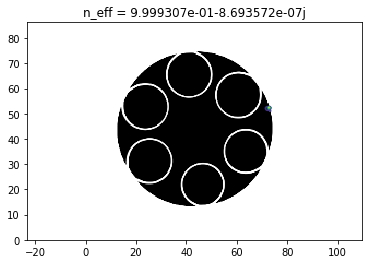

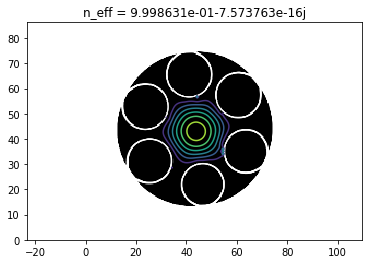

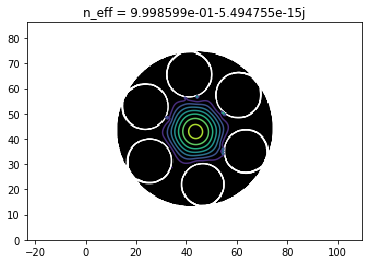

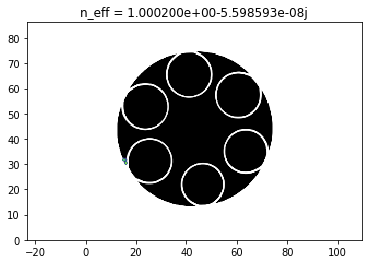

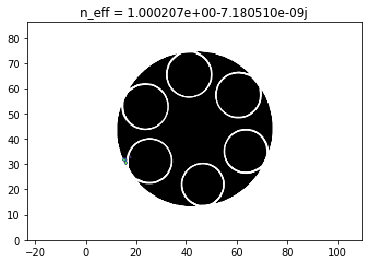

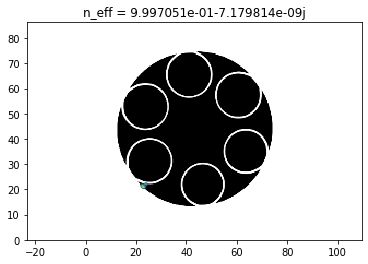

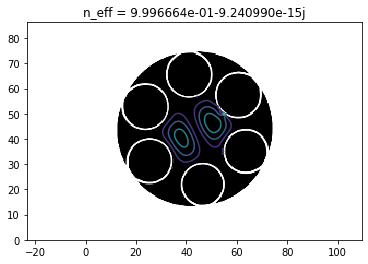

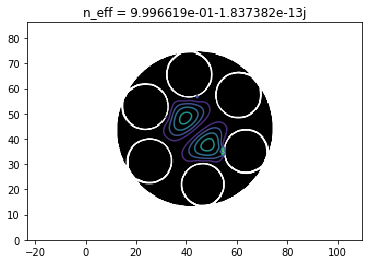

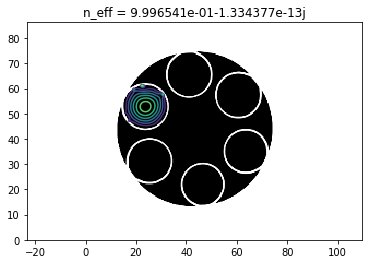

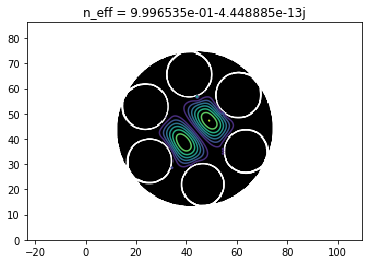

In [4]:

shape = np.insert(np.flip(np.shape(leakymodes.n)[:2]),0,nmodes)
E = leakymodes.Ex.reshape(shape)

for i in range(nmodes):
    neff = leakymodes.beta[i]/k 
    plt.figure()
    plt.title('n_eff = {:e}'.format(neff))
    plt.pcolormesh(leakymodes.x, leakymodes.y, n[:,:,0].real, cmap = 'Greys_r')
    plt.contour(leakymodes.x, leakymodes.y, abs(E[i,:,:]).transpose())
    plt.axis('equal')
    plt.show()
 

(10, 40000)
(40000,)


<ipython-input-5-e6671b7b8798>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(leakymodes.x, leakymodes.y, abs(E[1,:,:]).transpose())


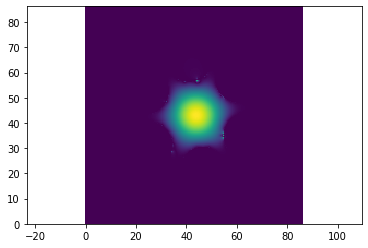

In [5]:
# we grab a mode to help us later 
print(np.shape(leakymodes.Ex))
E_norm = leakymodes.Ex[1,:] / sum(abs(leakymodes.Ex[1,:]))
plt.pcolormesh(leakymodes.x, leakymodes.y, abs(E[1,:,:]).transpose())
plt.axis('equal')
print(np.shape(E_norm))

We have fundimental modes :) We will sweep our structure across a range of wavelength and calculates some optical properties of the structure. If your computer is as low spec as mine this might take a while. 

In [12]:
steps = 30
lam_sweep = np.linspace(.6,2., steps)
beta_sweep = []
Ex_field = []
Ey_field = []
for lam in lam_sweep:
    n = (RefSilica(lam) - 1.) * bmp_to_array('hollow_core.bmp')[:,:,np.newaxis] + 1.
    n = np.repeat(n,3, axis = 2) 
    n_P = n_PML(n, dx, r_PML, lam)
    k = 2*cst.pi / lam 
    leakymodes = phil_class(n_P, k, dx = dx, dy = dx) 
    leakymodes.build_stuff(matrices = True)
    leakymodes.solve_stuff(nmodes, k)
    beta_sweep.append(leakymodes.beta)
    Ex_field.append(leakymodes.Ex)
    Ey_field.append(leakymodes.Ey)
     
    
    

Assembling matrix for 40000 grid points...

and we are done (after 7.917621374130249 secs).
Solving eigenmodes on CPU
36.54213190078735 secs later we have the final solution.
Assembling matrix for 40000 grid points...

and we are done (after 7.88713812828064 secs).
Solving eigenmodes on CPU
24.645470142364502 secs later we have the final solution.
Assembling matrix for 40000 grid points...

and we are done (after 7.9062340259552 secs).
Solving eigenmodes on CPU
21.516775369644165 secs later we have the final solution.
Assembling matrix for 40000 grid points...

and we are done (after 7.837231874465942 secs).
Solving eigenmodes on CPU
29.281877279281616 secs later we have the final solution.
Assembling matrix for 40000 grid points...

and we are done (after 7.794409990310669 secs).
Solving eigenmodes on CPU
18.879653215408325 secs later we have the final solution.
Assembling matrix for 40000 grid points...

and we are done (after 7.797911167144775 secs).
Solving eigenmodes on CPU
21.534

In [ ]:
# Now we search through the modes by calculating the overlap with of the x and y component of the fundimental this should catch both fundimental mode polarisations
loss = []
beta_filtered = []
for ex, ey, beta in zip(Ex_field, Ey_field, beta_sweep):
    overlap = abs(ex * E_norm[np.newaxis, :]) + abs(ey * E_norm[np.newaxis, :])
    mode_product = np.sum(overlap , axis = 1)
    for i in range(2):
        mode_track = np.argmax(mode_product)
        loss_db = -10 * beta.imag[mode_track] * 1E6 * np.log10(np.exp(1))
        loss.append(loss_db)
        beta_filtered.append(beta.real[mode_track])
        mode_product[mode_track] = 0
        #plt.figure()
        #plt.pcolormesh(overlap.reshape(shape)[mode_track, :,:])
        



(60,)


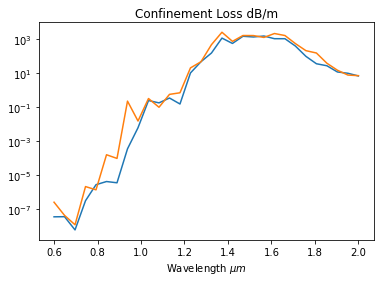

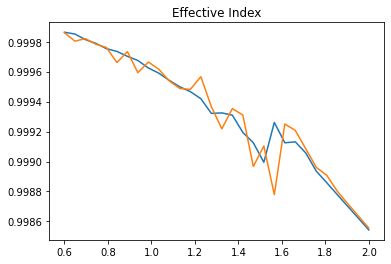

In [14]:
print(np.shape(loss))
loss_plot = np.reshape(loss, [steps,2])
neff = np.reshape(beta_filtered, [steps,2]) * lam_sweep[:,np.newaxis] / (2.* cst.pi)

plt.figure()
plt.title('Confinement Loss dB/m')
plt.semilogy(lam_sweep, loss_plot)
plt.xlabel('Wavelength $\mu m$')

Insidious (2010),
plt.figure()
plt.title('Effective Index')
plt.plot(lam_sweep, neff)

          

These results leave something to be desired but it's a start anyway. 